# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação.

# Base de dados e importações

In [ ]:
!gdown --id 1AXsjBK_TAAWgiWKq-68xuc91btNcLRcW --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1AXsjBK_TAAWgiWKq-68xuc91btNcLRcW
To: /content/dados.zip
35.2MB [00:00, 49.3MB/s]
Archive:  dados.zip
   creating: content/audios_MFCC_especialistas/
  inflating: content/audios_MFCC_especialistas/350e8396-e67e-491a-89dd-666702548d63.jpg  
  inflating: content/audios_MFCC_especialistas/811d96a7-e63f-4a8e-afc8-d8cef7bec7aa.jpg  
  inflating: content/audios_MFCC_especialistas/b408553b-befa-4a28-ab99-a10bb23384fc.jpg  
  inflating: content/audios_MFCC_especialistas/c91f755a-e37e-4106-a90a-bb0672fdfd24.jpg  
  inflating: content/audios_MFCC_especialistas/c35098aa-e1d0-41f2-94b3-38e98f389c9f.jpg  
  inflating: content/audios_MFCC_especialistas/bb84b88b-acd0-4975-8d43-0d0ebbf071f3.jpg  
  inflating: content/audios_MFCC_especialistas/43df4f16-fb75-43bb-a866-5231a9243e21.jpg  
  inflating: content/audios_MFCC_especialistas/e1259ecf-0b60-4106-9852-61c945065ab1.jpg  
  inflating: content/audios_MFCC_especialistas/aa78817e-f5e3-470b-b516-6006c59

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

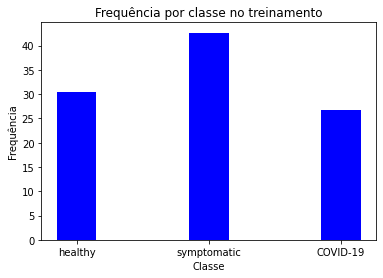

In [ ]:
plt.bar(0, len(train.values[train.classInt.values == 0])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(1, len(train.values[train.classInt.values == 1])/len(train.values) * 100, width=0.3, color='blue')
plt.bar(2, len(train.values[train.classInt.values == 2])/len(train.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no treinamento')
plt.savefig('Treinamento-especialista.png')

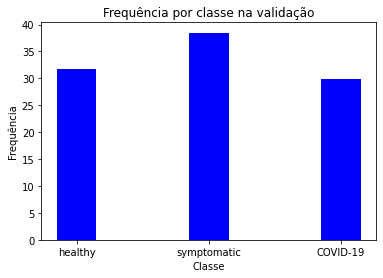

In [ ]:
plt.bar(0, len(val.values[val.classInt.values == 0])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(1, len(val.values[val.classInt.values == 1])/len(val.values) * 100, width=0.3, color='blue')
plt.bar(2, len(val.values[val.classInt.values == 2])/len(val.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe na validação')
plt.savefig('Validacao.png')

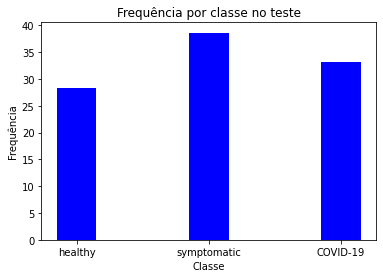

In [ ]:
teste = pd.read_csv('/content/CSV/test.csv')
teste['classInt'] = teste['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
plt.bar(0, len(teste.values[teste.classInt.values == 0])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(1, len(teste.values[teste.classInt.values == 1])/len(teste.values) * 100, width=0.3, color='blue')
plt.bar(2, len(teste.values[teste.classInt.values == 2])/len(teste.values) * 100, width=0.3, color='blue')
plt.ylabel('Frequência')
plt.xlabel('Classe')
plt.xticks([0, 1, 2], ['healthy','symptomatic','COVID-19'])
plt.title('Frequência por classe no teste')
plt.savefig('Teste.png')

# Função para treinamento de modelos

In [ ]:
!pip install vit-keras

     |████████████████████████████████| 686kB 14.2MB/s 


In [ ]:
from vit_keras import vit, utils

image_size = 256
model = vit.vit_l32(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=3
)

1226661888/1226658854 [==============================] - 24s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:79: UserWarning: Resizing position embeddings from 12 to 8
  UserWarning,


In [ ]:
def cria_e_treina_rede(model, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', epochs=500, class_weights=class_weights, trainable=True):

  preprocessing_function = vit.preprocess_inputs

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/content/audios_MFCC_especialistas', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelo

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
35/35 [==============================] - 76s 1s/step - loss: 1.7717 - acc: 0.3114 - val_loss: 1.1058 - val_acc: 0.3237
Epoch 2/500
35/35 [==============================] - 31s 900ms/step - loss: 1.4226 - acc: 0.3564 - val_loss: 1.0940 - val_acc: 0.4029
Epoch 3/500
35/35 [==============================] - 31s 899ms/step - loss: 1.3949 - acc: 0.3816 - val_loss: 1.1347 - val_acc: 0.2770
Epoch 4/500
35/35 [==============================] - 32s 900ms/step - loss: 1.3802 - acc: 0.4050 - val_loss: 1.1414 - val_acc: 0.2914
Epoch 5/500
35/35 [==============================] - 31s 899ms/step - loss: 1.3691 - acc: 0.4158 - val_loss: 1.1896 - val_acc: 0.2986
Epoch 6/500
35/35 [==============================] - 31s 899ms/step - loss

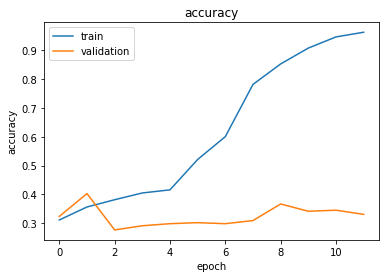

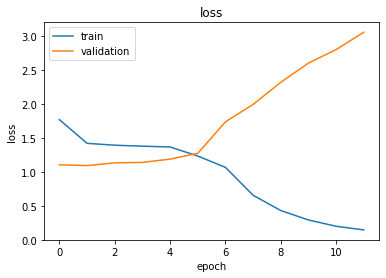

9/9 [==============================] - 7s 287ms/step
[[15 73  0]
 [10 97  0]
 [16 67  0]]
Acuracia balanceada na validacao: 0.35899886717643725


In [ ]:
lmodel = cria_e_treina_rede(model, train, val, callbacks=['earlystopping', 'reducelr'])